# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [ ]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

In [1]:
import re
import sys
import numpy as np
import pandas as pd
import pickle

from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC



In [2]:
# load data from database
engine = create_engine('sqlite:///C:\\Users\\lv974m\\Documents\\u1up0ng\\data_scientist\\03_data_engineering\\Project_Disaster_Recovery\\data\\DisasterResponse.db')
df = pd.read_sql('DisasterResponse', con=engine)


### Explore Data

In [ ]:
# check only 
df.tail(1)

In [35]:
category_count =list((df.drop(df.iloc[:, :5], axis = 1)
    .sum(axis = 0, skipna = True)
    .sort_values(ascending=False).values)*100/len(df))

In [36]:
category_count

[41.42508391821788,
 27.834147085749162,
 19.358407079646017,
 17.065913945682027,
 13.144644491913335,
 11.149679584986268,
 9.364510222764723,
 9.318736649374427,
 8.826670735428745,
 8.220170888007324,
 7.949343912114739,
 6.503661885871224,
 6.377784559047909,
 5.248703082087275,
 5.084681110772047,
 5.008391821788221,
 4.581171803478791,
 4.554470552334452,
 4.390448581019225,
 3.337656393042417,
 3.2804394263045467,
 2.7616722612145255,
 2.3039365273115653,
 2.0292950869697894,
 2.021666158071407,
 1.796612755569118,
 1.54485810192249,
 1.178669514800122,
 1.1367104058590174,
 1.0794934391211475,
 1.0756789746719562,
 0.606499847421422,
 0.45773573390296,
 0.45010680500457734,
 0.0]

<AxesSubplot:>

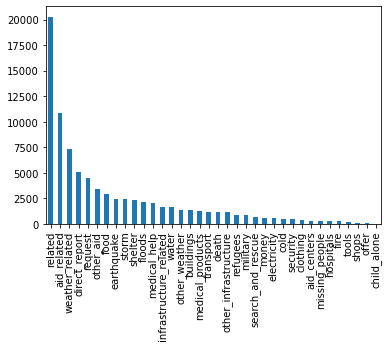

In [3]:
# bar graph of data, check only
%matplotlib inline
(df.drop(df.iloc[:, :4], axis = 1)
 .sum(axis = 0, skipna = True)
 .sort_values(ascending=False)
 .plot.bar())

In [ ]:
# create X, y
X = df['message'].values
y = df.iloc[:,5:].values # exclude related, I don't know what this is for

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    '''
    create lemmatized tokens from input texts
    
    input:          text
    output:         clean tokens
    '''
    # remove punctuation, idea cam
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # initiate
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # remove stop words
    tokens = [t for t in tokens if t not in stopwords.words("english")]
    
    # simplify words, nouns
    clean_tokens = [lemmatizer.lemmatize(tok.lower().strip()) for tok in tokens]
    
    # simplfiy words, verb
    clean_tokens = [lemmatizer.lemmatize(tok, pos='v') for tok in clean_tokens]

    return clean_tokens

In [ ]:
#check only
print(X[0])
print(tokenize(X[0]))

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

```python
#create pipeliine
pipeline = Pipeline([
    ('text_pipeline', Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer())
    ])),
    
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])
```

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
# split data test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

```python
# train pipeline
pipeline.fit(X_train,y_train)
```

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

```python
# predict
y_pred = pipeline.predict(X_test)
```

```python
# evaluate
target_names = df.iloc[:, 5:].columns
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
```

```python
Pipeline(steps=[('text_pipeline',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(tokenizer=<function tokenize at 0x000001A9E6B30EE8>)),
                                 ('tfidf', TfidfTransformer())])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=9,
                                                                        max_features='log2',
                                                                        min_samples_leaf=2,
                                                                        n_estimators=190,
                                                                        random_state=42)))])

```

### 6. Improve your model
Use grid search to find better parameters. 

```python
#check only
pipeline.get_params()
```

```python
# multiple parameters ahve been tried, this is the only one being exposed
parameters = {'clf__estimator__n_estimators': [190, 200],
              'clf__estimator__min_samples_split': [2, 3]}
              
cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=parameters, cv = 3)
```

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

```python
#fit
cv.fit(X_train, y_train)
```

```python
# predict
y_pred = cv.predict(X_test)
target_names = df.iloc[:, 5:].columns
print(classification_report(y_test, y_pred, target_names=target_names))
```

               precision    recall  f1-score   support
               request       0.85      0.50      0.63      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.74      0.69      0.72      3545
          medical_help       0.68      0.08      0.15       701
      medical_products       0.80      0.06      0.12       446
     search_and_rescue       0.44      0.02      0.03       226
              security       0.00      0.00      0.00       160
              military       0.62      0.06      0.10       267
           child_alone       0.00      0.00      0.00         0
                 water       0.87      0.42      0.57       543
                  food       0.87      0.57      0.69       965
               shelter       0.82      0.34      0.49       775
              clothing       0.74      0.11      0.19       127
                 money       0.75      0.03      0.06       191
        missing_people       0.00      0.00      0.00       104
              refugees       0.46      0.02      0.04       293
                 death       0.91      0.13      0.22       406
             other_aid       0.56      0.04      0.07      1139
    infrastructure_related       0.00      0.00      0.00       568
             transport       0.74      0.07      0.13       407
             buildings       0.82      0.10      0.19       441
           electricity       0.83      0.03      0.05       185
                 tools       0.00      0.00      0.00        53
             hospitals       0.00      0.00      0.00        85
                 shops       0.00      0.00      0.00        34
           aid_centers       0.00      0.00      0.00       115
      other_infrastructure       0.00      0.00      0.00       383
       weather_related       0.84      0.71      0.77      2390
                floods       0.88      0.51      0.64       693
                 storm       0.76      0.54      0.63       812
                  fire       0.00      0.00      0.00        90
            earthquake       0.88      0.79      0.83       787
                  cold       0.83      0.05      0.10       187
         other_weather       0.64      0.02      0.04       452
         direct_report       0.78      0.35      0.49      1694

             micro avg       0.80      0.40      0.53     20774
             macro avg       0.52      0.18      0.23     20774
          weighted avg       0.71      0.40      0.47     20774
           samples avg       0.41      0.24      0.28     20774

```python
# find best parameters
cv.best_estimator_
```

```python
Pipeline(steps=[('text_pipeline',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(tokenizer=<function tokenize at 0x000001E50A561438>)),
                                 ('tfidf', TfidfTransformer())])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                                        random_state=42)))]
```

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
#create pipeline for SVC
pipeline = Pipeline([
    ('text_pipeline', Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer())
    ])),
    
    ('clf', MultiOutputClassifier(OneVsRestClassifier(SVC(kernel='linear', 
                                                          random_state=42))))
])

In [ ]:
#check only
pipeline.get_params()

In [ ]:
# multiple parameters ahve been tried, this is the only one being exposed
parameters = {'clf__estimator__estimator__C': [2, 3]}

cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=parameters, cv = 3)

In [ ]:
# train pipeline
cv.fit(X_train,y_train)

In [ ]:
# predict
y_pred = cv.predict(X_test)

In [ ]:
# evaluate
target_names = df.iloc[:, 5:].columns
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

In [ ]:
# find best parameters
print(cv.best_estimator_)

### 9. Export your model as a pickle file

In [ ]:
#export to pickle
pickle.dump(pipeline, open('../models/classifier.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

u1up0ng 20200907